## why cross-entropy loss is popular for training neural networks

Cross-entropy loss can be used when the outputs of your network are between 0 and 1. For example, when you have a binary classification problem and you run the last layer's output through a *sigmoid layer*. Or when you have a multiclass classification problem and you run the last layer's output through a *softmax layer*.

One advantage is that the cross-entropy loss function has some very nice properties that make neural networks learn efficiently. In particular, the cross-entropy loss explodes for observations where the predicted probabilities are very bad. For these observations, the *gradient* will be very large. Thus, in the update-step, you will make a very large step towards a better prediction. Thus you will learn faster.

In this image you can see the cross-entropy loss of an individual observation that has a true label of 1. 

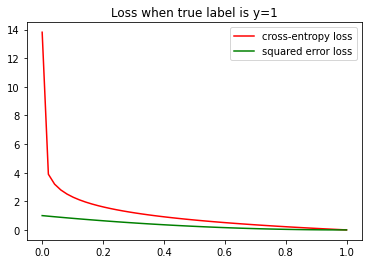

In [107]:
# cross-entropy loss when true label is y=1
pred_probs = np.linspace(1e-6, 1, 50)
cross_entropy_loss = -np.log(pred_probs)
sq_errors = (1-pred_probs)**2

plt.plot(pred_probs, cross_entropy_loss, "r-", label="cross-entropy loss")
plt.plot(pred_probs, sq_errors, "g-", label="squared error loss")
plt.legend()
plt.title("Loss when true label is y=1")
plt.show()

Note that the loss explodes when the model predicts a probability $\approx 0$. In that scenario, the model is very *confident* about its prediction, even though it is wrong.

Because the loss explodes for bad predictions, the slope/gradient will be very large, thus the update step will be very large.

In contrast, for the squared error loss, very bad predictions are not punished as much. Thus the update-step will not be as large. Thus you will make slower progress towards better predictions.

<img style="max-width:500px;" src="https://i.imgur.com/E8FUSg7.png"></img>


## Hypothesis: A classifier network trained using Cross-Entropy Loss learns better than a network trained using MSE loss.

To test this hypothesis, I train two networks that are identical, except for the loss functions used to train each network.

* network 1 uses `CrossEntropyLoss`
* network 2 uses `MSELoss`

I test the hypothesis using **MNIST**.

In [109]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.datasets

import torch.nn as nn
import torch.optim

from tqdm import trange

In [110]:
data_train = torchvision.datasets.MNIST( 
    root="./mnist_data",
    train=True,
    transform=torchvision.transforms.ToTensor()
    # download=True <-- if you don't have MNIST on disk
) 

data_test = torchvision.datasets.MNIST(
    root="./mnist_data",
    train=False,
    transform=torchvision.transforms.ToTensor()
    # download=True <-- if you don't have MNIST on disk
)

X_train, y_train = data_train.data, data_train.targets
# X_train, y_train = data_train.data.numpy(), data_train.targets.numpy()

# normalize X_train to [0, 1]
X_train = X_train / 255.0

X_train.shape, y_train.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [111]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        """
        Args:
            x: torch.array shaped (batch_size, height, width)
            
        Returns:
            torch.array shaped (batch_size, n_classes) of unnormalized scores (not probabilities)
        """
        scores = self.model(x)
        return scores

In [116]:
# Example output of the network
BS = 1
X = X_train[:BS].reshape((BS, -1))
y = y_train[:BS]

net = Net()
scores = net(X)
probs = nn.functional.softmax(scores, dim=1)

print(scores)
print(probs)

tensor([[-0.0599, -0.0067,  0.0696, -0.0077, -0.0799,  0.0152,  0.0754,  0.0909,
         -0.0234,  0.0373]], grad_fn=<AddmmBackward>)
tensor([[0.0930, 0.0981, 0.1059, 0.0980, 0.0912, 0.1003, 0.1065, 0.1081, 0.0965,
         0.1025]], grad_fn=<SoftmaxBackward>)


In [120]:
# Check if I correctly understood CrossEntropyLoss by calculating it
# (1) manually, and (2) using pytorch

BS = 3
X = X_train[:BS].reshape((BS, -1))
y = y_train[:BS]

net = Net()

# cross-entropy loss calculated manually
scores = net(X)
probs = nn.functional.softmax(scores, dim=1)
prob_true_class = probs[np.arange(probs.shape[0]), y]
loss_manual = -torch.log(prob_true_class)

# cross-entropy loss calculated manually
criterionCE = nn.CrossEntropyLoss(reduction="none")
loss_CE = criterionCE(scores, y) 
# CrossEntropyLoss combines softmax+CrossEntropy, thus you don't need to 
# run the scores through a softmax, before they enter the loss function.

print(loss_manual)
print(loss_CE)

tensor([2.3774, 2.1471, 2.3739], grad_fn=<NegBackward>)
tensor([2.3774, 2.1471, 2.3739], grad_fn=<NllLossBackward>)


In [122]:
data_train = torchvision.datasets.MNIST(
    root="./mnist_data",
    train=True,
    transform=torchvision.transforms.ToTensor()
    # download=True <-- if you don't have MNIST on disk
) 

data_test = torchvision.datasets.MNIST(
    root="./mnist_data",
    train=False,
    transform=torchvision.transforms.ToTensor()
    # download=True <-- if you don't have MNIST on disk
)

train_loader = torch.utils.data.DataLoader(dataset=data_train, batch_size=32)

In [74]:
LEARN_RATE = 0.1
EPOCHS = 10

# init network with cross-entropy loss
net1 = Net()
crit1 = nn.CrossEntropyLoss()
optim1 = torch.optim.SGD(net1.parameters(), lr = LEARN_RATE)

# init network with mse loss
net2 = Net()
crit2 = nn.MSELoss()
optim2 = torch.optim.SGD(net2.parameters(), lr = LEARN_RATE)

#TODO: weight initialization
# https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

# training
losses1 = []
losses2 = []
accuracies1 = []
accuracies2 = []
for i in trange(EPOCHS):
    acc_minibatches1 = []
    acc_minibatches2 = []
    for batch_id, (X, y) in enumerate(train_loader):
        batch_size, n_channels, h, w = X.shape
        
        # remove dimension for color channels, since our images are grayscale
        # from: [batch_size, n_channels, height, width]
        # to:   [batch_size, height, width]
        X = X.reshape((batch_size, h, w))
        X = X.reshape((batch_size, -1))
        
        net1.zero_grad()
        net2.zero_grad()
        
        scores1 = net1(X)
        scores2 = net2(X)
        
        probs1 = nn.functional.softmax(scores1, dim=1)
        probs2 = nn.functional.softmax(scores2, dim=1)
        prob_of_target = probs2[torch.arange(batch_size), y]
        
        loss1 = crit1(scores1, y) # CrossEntropyLoss has inbuilt softmax
        loss2 = crit2(prob_of_target, y.to(torch.float32))
        
        loss1.backward()
        loss2.backward()
        
        optim1.step()
        optim2.step()
        
        pred_labels1 = torch.argmax(probs1, dim=1)
        pred_labels2 = torch.argmax(probs2, dim=1)
        
        accuracy1 = float(torch.sum(pred_labels1 == y)) / batch_size
        accuracy2 = float(torch.sum(pred_labels2 == y)) / batch_size
        
        losses1.append(loss1)
        losses2.append(loss2)
        
        acc_minibatches1.append(accuracy1)
        acc_minibatches2.append(accuracy2)
    
    # avg accuracy per epoch
    accuracies1.append(np.mean(acc_minibatches1))
    accuracies2.append(np.mean(acc_minibatches2))



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:21<00:00, 14.18s/it]


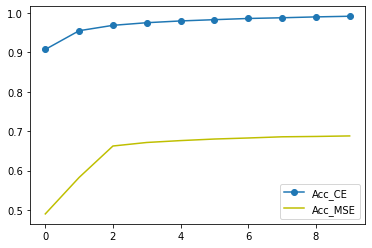

In [75]:
# plt.plot(losses1, "r-", label="Loss_CE")
# plt.plot(losses2, "g-", label="Loss_MSE")
plt.plot(accuracies1, "o-", label="Acc_CE")
plt.plot(accuracies2, "y-", label="Acc_MSE")
plt.legend()
plt.show()

In [123]:
print("Final Accuracies:")
print(f"Network with CrossEntropyLoss: Train Loss={accuracies1[-1]*100}%")
print(f"Network with MSE Loss: Train Loss={accuracies2[-1]*100}%")

Final Accuracies:
Network with CrossEntropyLoss: Train Loss=99.18%
Network with MSE Loss: Train Loss=68.795%


=> Network trained using CrossEntropyLoss trained better...